# Grabbing processed data

In [1]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np
# need to grab mean and std for each column so that we can normalize the df and apply clustering

joined = spark.read.parquet('./../FINAL_processed_data')
print(joined.printSchema())

columns = joined.columns



# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column for normalization
'''
for column in columns:
    if column != 'Season' and column!= 'record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))
'''


# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season' and column!='record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))




root
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- Season: long (nullable = true)
 |-- origin_prcp: long (nullable = true)
 |-- origin_tmax: long (nullable = true)
 |-- origin_tmin: long (nullable = true)
 |-- origin_awnd: long (nullable = true)
 |-- dest_prcp: long (nullable = true)
 |-- dest_tmax: long (nullable = true)
 |-- dest_tmin: long (nullable = true)
 |-- dest_awnd: long (nullable = true)
 |-- record_id: long (nullable = true)

None
Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857406145, origin_long_mean=-92.27161607308254, dest_lat_mean=37.09915724198568, des

## Plotting Locations of Clusters from season =0 (winter) and k=9 and 5 representatives per cluster based on elbow plot

In [2]:
season = 3
k = 8
num_reps = 7
fraction = 0.2

In [3]:
if season !=4:
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
else:
    # then we want all data
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
print(clusters.printSchema())

root
 |-- representative:1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:3: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:4: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:5: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:6: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:7: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [4]:
# selecting origin latitude and longitude of clusters
# these are the fifth and sixth elements of the records

# locations holds DENORMALIZED (latitude, longitude, cluster_id) tuples for representatives in each cluster
origin_locations = []
destination_locations = []
clusters = clusters.collect()
for i,cluster in enumerate(clusters):
    for representative in cluster:
        denormalized_lat = (representative[4] * stats['origin_lat_stddev']) + stats['origin_lat_mean']
        denormalized_long = (representative[5] * stats['origin_long_stddev']) + stats['origin_long_mean']
        denormalized_dest_lat = (representative[6] * stats['dest_lat_stddev'])+ stats['dest_lat_mean']
        denormalized_dest_long = (representative[7] * stats['dest_long_stddev']) + stats['dest_long_mean']
        origin_locations.append((denormalized_lat,denormalized_long,i))
        destination_locations.append((denormalized_dest_lat,denormalized_dest_long,i))
print(origin_locations)

[(32.676403322071074, -104.11999853078991, 0), (40.81474598607106, -89.34132538678995, 0), (21.982603322071107, -71.81922071479, 0), (38.46798421007106, -86.74749205078996, 0), (21.982603322071107, -71.81922071479, 0), (40.81474598607106, -89.34132538678995, 0), (31.21544776207108, -95.28953182678994, 0), (40.28003301940416, -131.51384211917028, 1), (51.26030369140413, -153.66334011917021, 1), (19.039767243404217, -158.81075787917018, 1), (51.260303691404125, -153.66334011917021, 1), (35.90452346740417, -103.98996297517034, 1), (19.375800355404216, -160.00431739917022, 1), (51.26030369140413, -153.66334011917021, 1), (43.22131144592893, -82.16183298697442, 2), (43.22131144592893, -82.16183298697442, 2), (26.69258833392897, -138.17618741097428, 2), (45.542072997928926, -86.4117996509744, 2), (40.79326099792893, -73.80290942697445, 2), (42.19163322192893, -71.17319009897446, 2), (36.79166433392894, -106.56472117097437, 2), (46.22688179001065, -73.19533288449225, 3), (36.62758356601067, -

In [5]:
# getting packages we need
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install shapely

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


     latitude   longitude  cluster_id                     geometry
0   32.676403 -104.119999           0  POINT (-104.12000 32.67640)
1   40.814746  -89.341325           0   POINT (-89.34133 40.81475)
2   21.982603  -71.819221           0   POINT (-71.81922 21.98260)
3   38.467984  -86.747492           0   POINT (-86.74749 38.46798)
4   21.982603  -71.819221           0   POINT (-71.81922 21.98260)
5   40.814746  -89.341325           0   POINT (-89.34133 40.81475)
6   31.215448  -95.289532           0   POINT (-95.28953 31.21545)
7   40.280033 -131.513842           1  POINT (-131.51384 40.28003)
8   51.260304 -153.663340           1  POINT (-153.66334 51.26030)
9   19.039767 -158.810758           1  POINT (-158.81076 19.03977)
10  51.260304 -153.663340           1  POINT (-153.66334 51.26030)
11  35.904523 -103.989963           1  POINT (-103.98996 35.90452)
12  19.375800 -160.004317           1  POINT (-160.00432 19.37580)
13  51.260304 -153.663340           1  POINT (-153.66334 51.26

Text(0.5, 1.0, 'Origins of Representatives in Each Cluster ')

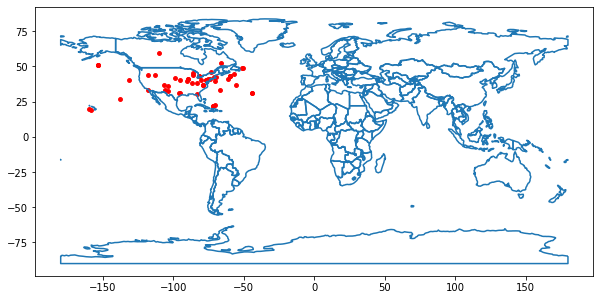

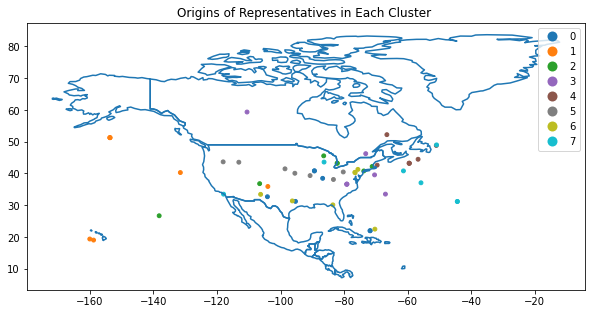

In [6]:
# plotting these latitude longitude values on a map with shapely and geopandas and making a graph for our origin representatives
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt


df = pd.DataFrame(origin_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);
plt.title('Origins of Representatives in Each Cluster ')

     latitude   longitude  cluster_id                     geometry
0   32.784971 -100.778165           0  POINT (-100.77816 32.78497)
1   39.385745  -80.427356           0   POINT (-80.42736 39.38575)
2   39.742750  -78.039774           0   POINT (-78.03977 39.74275)
3   40.814625  -89.340205           0   POINT (-89.34020 40.81463)
4   38.229099  -91.304625           0   POINT (-91.30463 38.22910)
5   38.467863  -86.746371           0   POINT (-86.74637 38.46786)
6   39.128511  -79.209546           0   POINT (-79.20955 39.12851)
7   29.474230 -128.385969           1  POINT (-128.38597 29.47423)
8   54.171143 -151.947245           1  POINT (-151.94725 54.17114)
9   19.375154 -159.997435           1  POINT (-159.99744 19.37515)
10  54.171143 -151.947245           1  POINT (-151.94725 54.17114)
11  51.259657 -153.656458           1  POINT (-153.65646 51.25966)
12  19.900987 -161.130676           1  POINT (-161.13068 19.90099)
13  54.171143 -151.947245           1  POINT (-151.94725 54.17

Text(0.5, 1.0, 'Destinations of Representatives In Each Cluster')

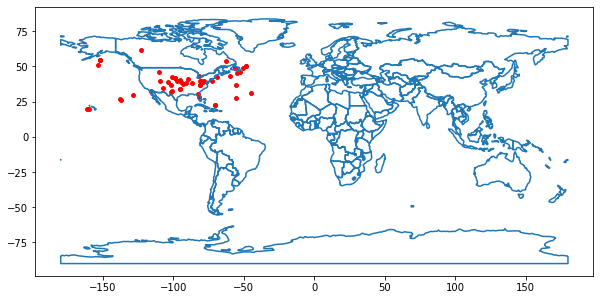

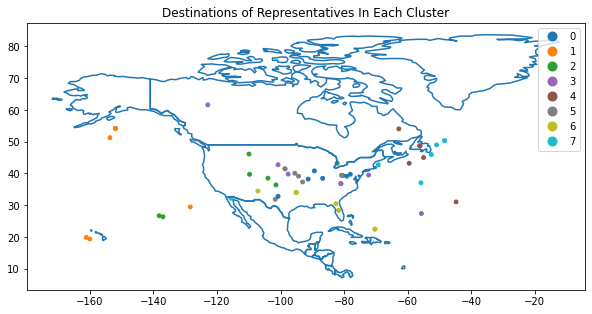

In [7]:
# plotting these latitude longitude values on a map with shapely and geopandas for our destination locations for each representative


df = pd.DataFrame(destination_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);

plt.title('Destinations of Representatives In Each Cluster')

## For each cluster, what is the delay distribution of elements within the cluster?

In [8]:
# grabbing mappings for each cluster for this configuration
if season !=4:
    mapping= spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)).coalesce(1)
else:
    # then we want all data
    mapping = spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)).coalesce(1)
print(mapping.printSchema())

# getting dep delay mean for each cluster in our clustering
# also getting the number of elements in each cluster
# also getting percentages (number of records with delay/all records)
means = []
counts = []
percentages = []
for i in range(len(clusters)):
    if season !=4:
        interested_elements = mapping.where(mapping.tag==i).join(joined.where(joined.Season==season).coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    else:
        interested_elements = mapping.where(mapping.tag==i).join(joined.coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    print('cluster: '+ str(i)+ ' mean depdelay: ' + str(mean))
    means.append(mean['avg(DepDelay)'])
    count = mapping.where(mapping.tag==i).count()
    counts.append(count)
    percentages.append(num_delay/count)
    print('cluster: ' + str(i) + ' number of examples tagged: ' + str(count))
    print('cluster: ' + str(i) + ' number of records with delay: ' + str(num_delay))
    
    
    
    
# getting the mean dep delay for the population and the total count
if season!=4:
    pop_mean = joined.where(joined.Season==season).select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.where(joined.Season==season).count()
else:
    pop_mean  = joined.select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.count()
print('population_mean: ' + str(pop_mean))
print('population count: ' + str(pop_count))




root
 |-- record_id: long (nullable = true)
 |-- tag: integer (nullable = true)

None
cluster: 0 mean depdelay: Row(avg(DepDelay)=4.053029834335366)
cluster: 0 number of examples tagged: 6530060
cluster: 0 number of records with delay: 2179760
cluster: 1 mean depdelay: Row(avg(DepDelay)=2.8455027020640338)
cluster: 1 number of examples tagged: 355469
cluster: 1 number of records with delay: 95982
cluster: 2 mean depdelay: Row(avg(DepDelay)=7.864618027330869)
cluster: 2 number of examples tagged: 4890075
cluster: 2 number of records with delay: 2280545
cluster: 3 mean depdelay: Row(avg(DepDelay)=12.497563117291353)
cluster: 3 number of examples tagged: 271043
cluster: 3 number of records with delay: 145276
cluster: 4 mean depdelay: Row(avg(DepDelay)=215.32732950563704)
cluster: 4 number of examples tagged: 81337
cluster: 4 number of records with delay: 80723
cluster: 5 mean depdelay: Row(avg(DepDelay)=5.599666602080017)
cluster: 5 number of examples tagged: 7338978
cluster: 5 number of 

## Plotting percentage of records with a delay per cluster

[]

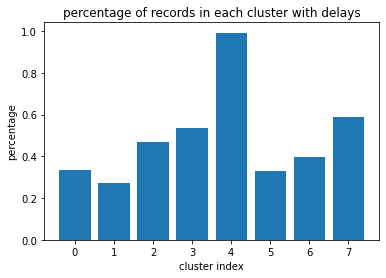

In [9]:
plt.bar([i for i in range(len(percentages))],percentages)
plt.xlabel('cluster index')
plt.ylabel('percentage')
plt.title('percentage of records in each cluster with delays')
plt.plot()

# Plotting number of examples per cluster

[]

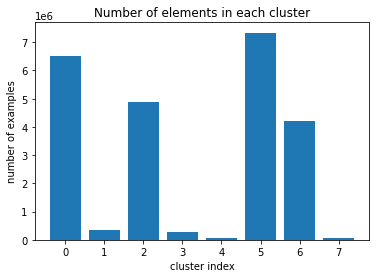

In [10]:
plt.bar([i for i in range(len(counts))],counts)
plt.xlabel('cluster index')
plt.ylabel('number of examples')
plt.title('Number of elements in each cluster')
plt.plot()

## Bar Plot for this Configuration

[]

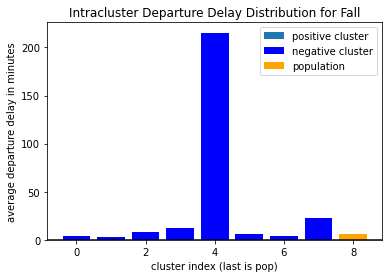

In [11]:

fig = plt.figure()
ax = plt.subplot(111)
positives = []
negatives  = []
for i in range(len(means)):
    if means[i]<0:
        negatives.append((i,means[i]))
    else:
        positives.append((i,means[i]))
#print(zip(*negatives))
first = ax.bar([index for index,value in negatives], [value for index,value in negatives],color='green')
second = ax.bar([index for index,value in positives], [value for index,value in positives],color='blue')
third = ax.bar([len(means)],[pop_mean],color='orange')
ax.axhline(0, color='k')
ax.legend((first,second,third),('positive cluster','negative cluster','population'))
plt.xlabel('cluster index (last is pop)')
plt.ylabel('average departure delay in minutes')
plt.title('Intracluster Departure Delay Distribution for Fall')
plt.plot()

## Cluster analysis for Cluster 4

In [12]:
# intracluster analysis
cluster_index = 4

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
    pop = joined.where(joined.Season==season).drop('Season','record_id')
    pop_stats = pop.select(*[[F.mean(c).alias(c+'_mean') for c in pop.columns] + \
                                     [F.stddev_pop(c).alias(c+'_stddev') for c in pop.columns]]).collect()[0]
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)
    pop_stats = stats

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=210.92188057095785, DepDelay_mean=215.32732950563704, ActualElapsedTime_mean=152.6073865522456, Distance_mean=818.8549122785448, origin_lat_mean=37.29672120230071, origin_long_mean=-85.34485391425436, dest_lat_mean=37.23273733932095, dest_long_mean=-85.80810761085172, origin_prcp_mean=82.67714570244785, origin_tmax_mean=250.40560876353936, origin_tmin_mean=149.39746978619817, origin_awnd_mean=46.71272606562819, dest_prcp_mean=101.53511931839138, dest_tmax_mean=247.8200449979714, dest_tmin_mean=148.57567896529255, dest_awnd_mean=42.497940666609296, ArrDelay_stddev=117.94232569724224, DepDelay_stddev=175.33726679250984, ActualElapsedTime_stddev=72.80358577638196, Distance_stddev=556.7604843648811, origin_lat_stddev=5.306318296690481, origin_long_stddev=12.995537311681062, dest_lat_stddev=5.37257329129384, dest_long_stddev=13.28057108441456, origin_prcp_stddev=197.02027709005864, origin_tmax_stddev=66.96573635062758, origin_tmin_stddev=62.61401586970835

## Plotting stats compared to average for delay attributes

In [13]:


# defining a function to make plots for us
def plot_features(labels,title,interested_stats,pop_stats):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    interested_vals = [interested_stats[label+'_mean'] for label in labels]
    interested_stddevs = [interested_stats[label+'_stddev'] for label in labels]
    pop_vals = [pop_stats[label+'_mean'] for label in labels]
    pop_stddevs = [pop_stats[label+'_stddev'] for label in labels]
    indices = np.arange(len(pop_vals))
    width = 0.35
    first = ax.bar(indices,interested_vals,width,label='cluster',yerr=interested_stddevs)
    second = ax.bar(indices+width,pop_vals,width,label='population',yerr=pop_stddevs)
    ax.set_xticks(indices+width/2)
    ax.set_xticklabels(labels)
    plt.ylabel('value')
    plt.xlabel('feature')
    ax.legend((first,second),('Cluster','Population'))
    plt.title(title)
    plt.plot()

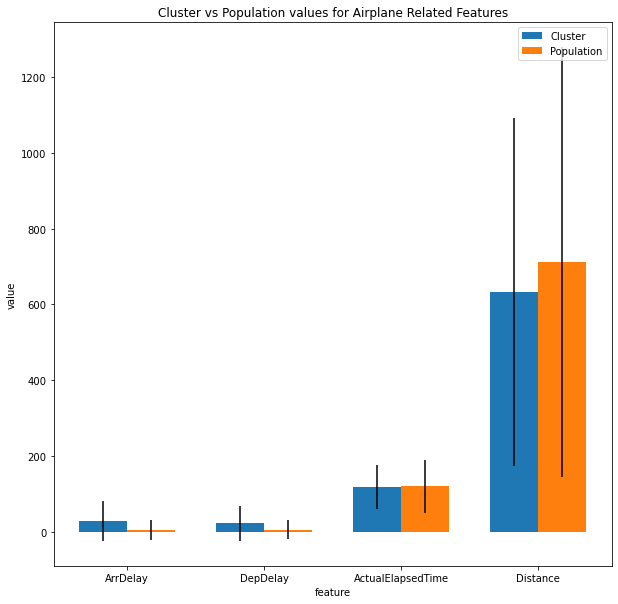

In [22]:
# flight related features
labels = ['ArrDelay', 'DepDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

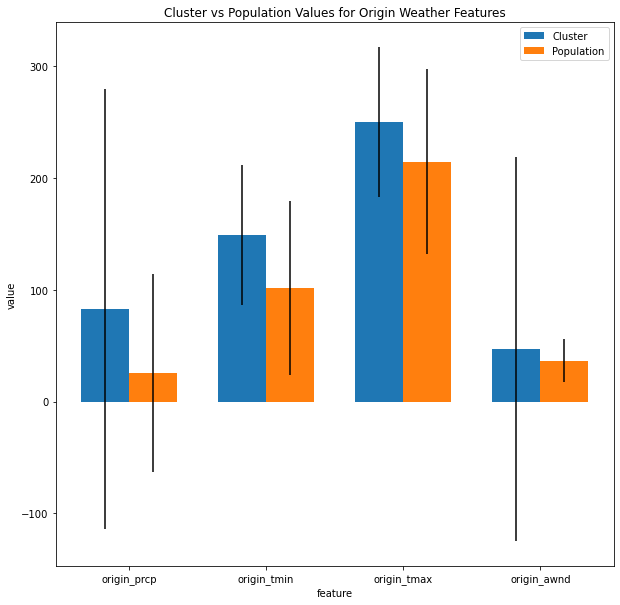

In [15]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

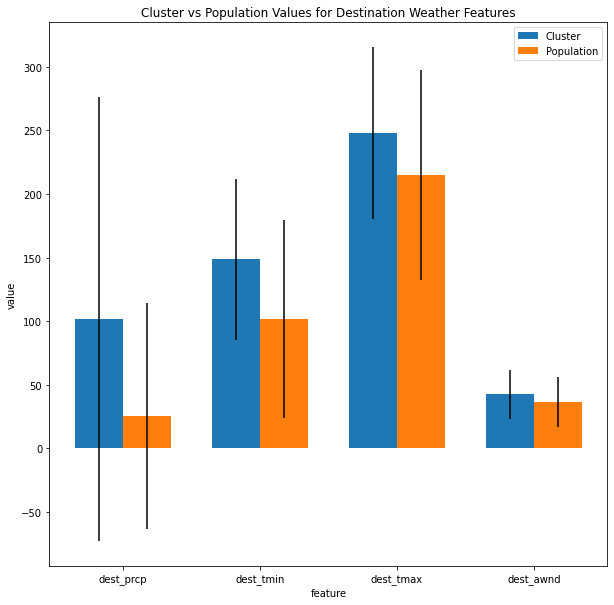

In [16]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## We have larger than average distance for the flight, much larger than average precipitation levels at both the origin and the destination of the flight. In addition, slightly higher than average windspeed. Based on the geographic map, these seem to be flights in the eastern region of the US.

# Analyzing another cluster with higher than average delay: Cluster 7

In [17]:
# intracluster analysis
cluster_index = 7

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=28.50109090909091, DepDelay_mean=22.886474501108648, ActualElapsedTime_mean=118.70506430155211, Distance_mean=632.3093392461197, origin_lat_mean=34.528382440031734, origin_long_mean=-87.23964343766417, dest_lat_mean=34.24106539887218, dest_long_mean=-86.26455567950904, origin_prcp_mean=443.0258270509978, origin_tmax_mean=246.00649223946786, origin_tmin_mean=157.41637250554325, origin_awnd_mean=43.54816851441242, dest_prcp_mean=747.2925232815965, dest_tmax_mean=242.4961596452328, dest_tmin_mean=163.621977827051, dest_awnd_mean=56.146181818181816, ArrDelay_stddev=52.217563913606305, DepDelay_stddev=46.865374665735594, ActualElapsedTime_stddev=58.95339737211308, Distance_stddev=458.7349030351491, origin_lat_stddev=5.482077786662466, origin_long_stddev=13.427371776832464, dest_lat_stddev=5.589902230374978, dest_long_stddev=12.47566200449357, origin_prcp_stddev=439.82728959468807, origin_tmax_stddev=60.567820720685056, origin_tmin_stddev=59.63002762796810

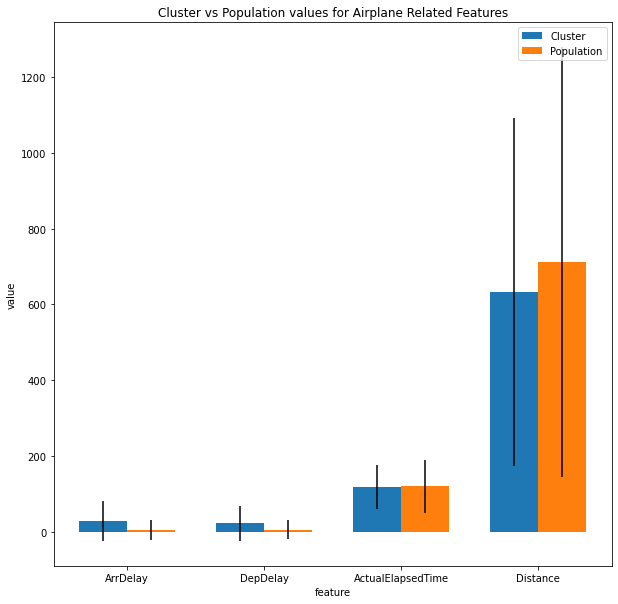

In [21]:
# flight related features
labels = ['ArrDelay', 'DepDelay','ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

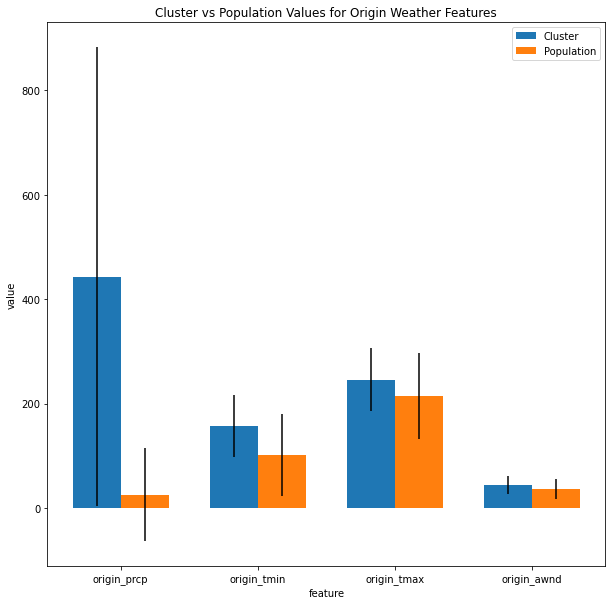

In [19]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

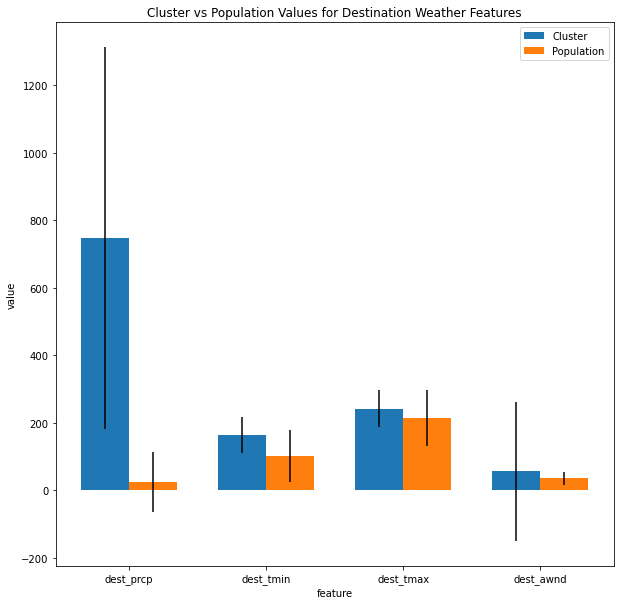

In [20]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

# We see a huge amount of precipitation, these flgihts also seem to be situated on the east coast of the United States